# Face Alignment Methods Comprehensive Benchmark

This notebook compares multiple face alignment methods on LFW dataset using EdgeFace-XS(γ=0.6) model.

## Methods Compared:
- **MTCNN**: Multi-task CNN (PyTorch)
- **YuNet**: OpenCV's fast face detection
- **RetinaFace**: ONNX-based RetinaFace
- **RTMPose**: Face keypoint detection
- **MediaPipe**: Google's face detection/mesh
- **YOLO**: YOLO-based face detection

## Evaluation Metrics:
- **Accuracy**: Face verification accuracy on LFW
- **ROC AUC**: Area under ROC curve
- **EER**: Equal Error Rate
- **Speed**: Processing time per image
- **Success Rate**: Percentage of successful alignments

In [1]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import time

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure Korean font (same as previous notebook)
import matplotlib.font_manager as fm

# Find Korean font
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
korean_fonts = []
for font in font_list:
    try:
        font_name = fm.FontProperties(fname=font).get_name()
        if any(korean in font_name.lower() for korean in ['nanum', 'malgun', 'gothic', 'dotum', 'gulim']):
            korean_fonts.append(font_name)
    except:
        continue

if korean_fonts:
    selected_font = korean_fonts[0]
    plt.rcParams['font.family'] = selected_font
    plt.rcParams['axes.unicode_minus'] = False
    print(f"한글 폰트 설정 완료: {selected_font}")
else:
    print("한글 폰트를 찾을 수 없습니다. 기본 폰트를 사용합니다.")

print("Setup completed!")

한글 폰트 설정 완료: Franklin Gothic Heavy
Setup completed!


## 1. Import and Initialize Components

In [2]:
# Add face_alignment to path
sys.path.insert(0, 'face_alignment')

# Import components
try:
    from face_alignment.unified_detector import UnifiedFaceDetector, benchmark_all_methods
    from lfw_evaluation import LFWEvaluator
    print("✅ All components imported successfully")
except ImportError as e:
    print(f"❌ Import error: {e}")
    print("Please ensure all required files are in place")

RetinaFace not available
RTMPose not available
Mediapipe not installed. Install with: pip install mediapipe
✅ All components imported successfully


## 2. Check Available Methods

In [3]:
# Check which methods are available
available_methods = UnifiedFaceDetector.list_available_methods()
dependency_status = UnifiedFaceDetector.check_dependencies()

print("📋 Method Availability Status:")
print("=" * 40)

for method, available in dependency_status.items():
    status = "✅" if available else "❌"
    print(f"{status} {method.upper()}: {'Available' if available else 'Not Available'}")

print(f"\n🎯 Total Available Methods: {len(available_methods)}")
print(f"📝 Methods to evaluate: {available_methods}")

📋 Method Availability Status:
✅ MTCNN: Available
✅ YUNET: Available
❌ RETINAFACE: Not Available
❌ RTMPOSE: Not Available
✅ MEDIAPIPE: Available
✅ MEDIAPIPE_SIMPLE: Available
✅ YOLO: Available
✅ YOLO_ULTRALYTICS: Available

🎯 Total Available Methods: 6
📝 Methods to evaluate: ['mtcnn', 'yunet', 'mediapipe', 'mediapipe_simple', 'yolo', 'yolo_ultralytics']


## 3. Quick Speed Benchmark (Sample Images)

In [4]:
# Create sample images for speed testing
sample_images = []
sample_dir = "/mnt/c/Users/Admin/Downloads/lfw-deepfunneled/lfw-deepfunneled"  # Updated path

# Try to find some sample images from LFW
if os.path.exists(sample_dir):
    for root, dirs, files in os.walk(sample_dir):
        for file in files[:5]:  # Get first 5 images
            if file.endswith(('.jpg', '.png')):
                sample_images.append(os.path.join(root, file))
        if len(sample_images) >= 3:
            break

if not sample_images:
    print("⚠️ No sample images found. Using synthetic data for demo.")
    # Create a dummy image for testing
    dummy_image = Image.new('RGB', (150, 200), color='lightblue')
    sample_images = [dummy_image]
else:
    print(f"📸 Found {len(sample_images)} sample images for speed testing")
    sample_images = [Image.open(img).convert('RGB') for img in sample_images[:3]]

📸 Found 3 sample images for speed testing


In [5]:
# FORCE RUN: Speed Benchmark Test
print("=" * 60)
print("🚨 FORCED EXECUTION OF CELL 8 - SPEED BENCHMARK")
print("=" * 60)

# Test sample images first
print(f"\n🔍 Sample Images Check:")
print(f"   Number of sample images: {len(sample_images) if 'sample_images' in globals() else 'Not defined'}")
if 'sample_images' in globals() and sample_images:
    print(f"   First image type: {type(sample_images[0])}")
    print(f"   First image size: {sample_images[0].size if hasattr(sample_images[0], 'size') else 'No size attr'}")

# Test available methods
print(f"\n🔍 Available Methods Check:")
if 'available_methods' in globals():
    print(f"   Methods: {available_methods}")
else:
    print("   ERROR: available_methods not defined")
    # Define it manually for testing
    from face_alignment.unified_detector import UnifiedFaceDetector
    available_methods = UnifiedFaceDetector.list_available_methods()
    print(f"   Manually loaded methods: {available_methods}")

# Now run actual speed benchmark
print(f"\n⏱️ RUNNING SPEED BENCHMARK...")
speed_results = {}
errors_encountered = []

if 'sample_images' in globals() and sample_images and 'available_methods' in globals():
    for i, method in enumerate(available_methods):
        print(f"\n[{i+1}/{len(available_methods)}] Testing {method.upper()}...")
        
        try:
            print(f"  Step 1: Creating detector...")
            detector = UnifiedFaceDetector(method, device='cpu')
            print(f"  Step 2: Checking availability: {detector.available}")
            
            if detector.available:
                print(f"  Step 3: Running benchmark...")
                # Simplified benchmark - just test align once
                start_time = time.time()
                aligned_face = detector.align(sample_images[0])
                end_time = time.time()
                
                alignment_time = end_time - start_time
                success = aligned_face is not None
                
                print(f"  Step 4: Results - Time: {alignment_time:.3f}s, Success: {success}")
                
                if success:
                    # Create simple result structure
                    speed_results[method] = {
                        'method': method,
                        'alignment_time': alignment_time,
                        'success': success,
                        'total_time': {'mean': alignment_time}
                    }
                    print(f"  ✅ {method.upper()}: {alignment_time:.3f}s")
                else:
                    print(f"  ⚠️ {method.upper()}: Alignment failed")
            else:
                print(f"  ❌ {method.upper()}: Detector not available")
                
        except Exception as e:
            error_msg = f"{method}: {str(e)}"
            errors_encountered.append(error_msg)
            print(f"  ❌ Error in {method}: {e}")
            import traceback
            traceback.print_exc()

else:
    print("❌ CRITICAL: Missing sample_images or available_methods")

print(f"\n📊 FINAL RESULTS:")
print(f"   Speed results count: {len(speed_results)}")
print(f"   Successful methods: {list(speed_results.keys())}")
print(f"   Errors encountered: {len(errors_encountered)}")

if errors_encountered:
    print(f"\n🐛 ERRORS:")
    for error in errors_encountered:
        print(f"   - {error}")

# Set this as global so Cell 10 can access it
globals()['speed_results'] = speed_results

print("=" * 60)
print("🔚 FORCED CELL 8 EXECUTION COMPLETE")
print("=" * 60)

🚨 FORCED EXECUTION OF CELL 8 - SPEED BENCHMARK

🔍 Sample Images Check:
   Number of sample images: 3
   First image type: <class 'PIL.Image.Image'>
   First image size: (250, 250)

🔍 Available Methods Check:
   Methods: ['mtcnn', 'yunet', 'mediapipe', 'mediapipe_simple', 'yolo', 'yolo_ultralytics']

⏱️ RUNNING SPEED BENCHMARK...

[1/6] Testing MTCNN...
  Step 1: Creating detector...
  Step 2: Checking availability: True
  Step 3: Running benchmark...
  Step 4: Results - Time: 0.035s, Success: True
  ✅ MTCNN: 0.035s

[2/6] Testing YUNET...
  Step 1: Creating detector...
  Step 2: Checking availability: True
  Step 3: Running benchmark...
  Step 4: Results - Time: 0.010s, Success: True
  ✅ YUNET: 0.010s

[3/6] Testing MEDIAPIPE...
  Step 1: Creating detector...
MediaPipe not available - detector disabled
  Step 2: Checking availability: True
  Step 3: Running benchmark...
  Step 4: Results - Time: 0.000s, Success: False
  ⚠️ MEDIAPIPE: Alignment failed

[4/6] Testing MEDIAPIPE_SIMPLE...


## 4. Visualize Speed Comparison

🚨 FORCED EXECUTION OF CELL 10 - VISUALIZATION

🔍 Speed Results Check:
   speed_results exists: True
   Number of results: 4
   Result keys: ['mtcnn', 'yunet', 'yolo', 'yolo_ultralytics']

📊 Individual Results:
   MTCNN:
     - Keys: ['method', 'alignment_time', 'success', 'total_time']
     - Total time: 0.035s
     - Success: True
   YUNET:
     - Keys: ['method', 'alignment_time', 'success', 'total_time']
     - Total time: 0.010s
     - Success: True
   YOLO:
     - Keys: ['method', 'alignment_time', 'success', 'total_time']
     - Total time: 0.039s
     - Success: True
   YOLO_ULTRALYTICS:
     - Keys: ['method', 'alignment_time', 'success', 'total_time']
     - Total time: 0.071s
     - Success: True

📈 CREATING SIMPLE VISUALIZATION...


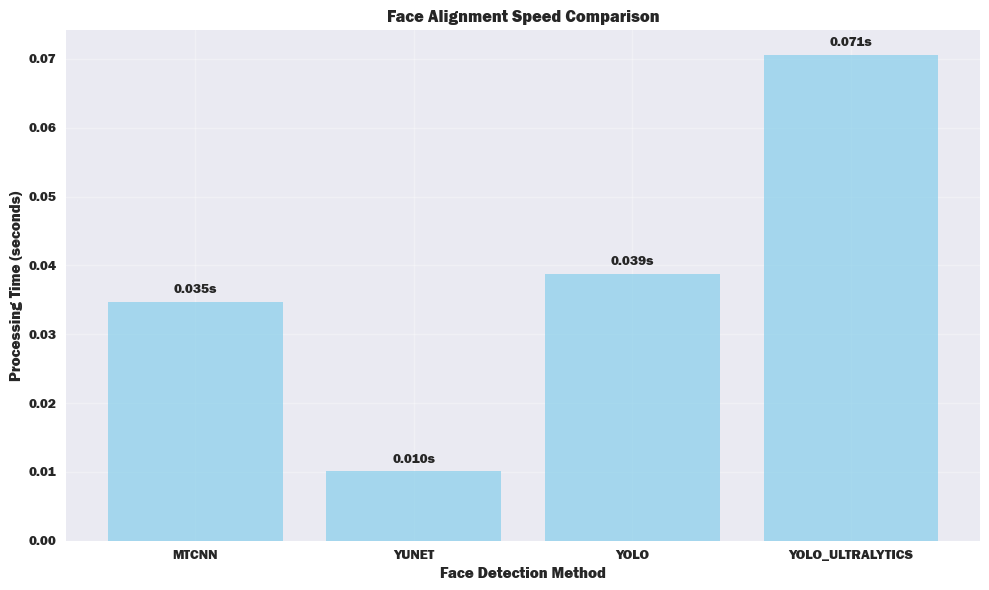


🏆 Speed Ranking (Fastest to Slowest):
1. YUNET: 0.010s
2. MTCNN: 0.035s
3. YOLO: 0.039s
4. YOLO_ULTRALYTICS: 0.071s

✅ VISUALIZATION SUCCESSFUL!
🔚 FORCED CELL 10 EXECUTION COMPLETE


In [6]:
# FORCE RUN: Visualization Test
print("=" * 60)
print("🚨 FORCED EXECUTION OF CELL 10 - VISUALIZATION")
print("=" * 60)

# Check if speed_results exists and has data
print(f"\n🔍 Speed Results Check:")
if 'speed_results' in globals():
    print(f"   speed_results exists: True")
    print(f"   Number of results: {len(speed_results)}")
    print(f"   Result keys: {list(speed_results.keys())}")
    
    if speed_results:
        print(f"\n📊 Individual Results:")
        for method, result in speed_results.items():
            print(f"   {method.upper()}:")
            print(f"     - Keys: {list(result.keys())}")
            if 'total_time' in result:
                print(f"     - Total time: {result['total_time']['mean']:.3f}s")
            if 'success' in result:
                print(f"     - Success: {result['success']}")
        
        # Simple visualization
        print(f"\n📈 CREATING SIMPLE VISUALIZATION...")
        
        methods = list(speed_results.keys())
        times = []
        
        for method in methods:
            if 'total_time' in speed_results[method]:
                time_val = speed_results[method]['total_time']['mean']
                times.append(time_val)
            elif 'alignment_time' in speed_results[method]:
                time_val = speed_results[method]['alignment_time']
                times.append(time_val)
            else:
                times.append(0.0)
        
        if any(t > 0 for t in times):
            # Create simple bar chart
            fig, ax = plt.subplots(1, 1, figsize=(10, 6))
            
            bars = ax.bar([m.upper() for m in methods], times, alpha=0.7, color='skyblue')
            ax.set_xlabel('Face Detection Method')
            ax.set_ylabel('Processing Time (seconds)')
            ax.set_title('Face Alignment Speed Comparison')
            ax.grid(True, alpha=0.3)
            
            # Add value labels
            for bar, time_val in zip(bars, times):
                if time_val > 0:
                    height = bar.get_height()
                    ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                            f'{time_val:.3f}s', ha='center', va='bottom', fontweight='bold')
            
            plt.tight_layout()
            plt.show()
            
            # Print ranking
            valid_times = [(method, time) for method, time in zip(methods, times) if time > 0]
            if valid_times:
                speed_ranking = sorted(valid_times, key=lambda x: x[1])
                
                print("\n🏆 Speed Ranking (Fastest to Slowest):")
                print("=" * 50)
                for i, (method, time) in enumerate(speed_ranking, 1):
                    print(f"{i}. {method.upper()}: {time:.3f}s")
            
            print(f"\n✅ VISUALIZATION SUCCESSFUL!")
        else:
            print(f"\n⚠️ All timing results are zero")
    else:
        print(f"\n⚠️ speed_results is empty")
else:
    print(f"   speed_results exists: False")
    print(f"   ERROR: speed_results not found in globals")

print("=" * 60)
print("🔚 FORCED CELL 10 EXECUTION COMPLETE")
print("=" * 60)

## 5. LFW Dataset Evaluation Setup

In [7]:
# LFW evaluation configuration
lfw_config = {
    'lfw_dir': '/mnt/c/Users/Admin/Downloads/lfw-deepfunneled/lfw-deepfunneled',
    'pairs_file': '/mnt/c/Users/Admin/Downloads/lfw-deepfunneled/pairs.csv',
    'edgeface_model_path': 'checkpoints/edgeface_xs_gamma_06.pt',  # Updated to correct path
    'device': 'cpu'
}

print("📋 LFW Evaluation Configuration:")
print("=" * 40)
for key, value in lfw_config.items():
    exists = "✅" if os.path.exists(value) else "❌" if isinstance(value, str) and value != 'cpu' else "⚙️"
    print(f"{exists} {key}: {value}")

# Check if we can run full LFW evaluation
can_run_lfw = all(os.path.exists(v) for k, v in lfw_config.items() if k not in ['device'])

if can_run_lfw:
    print("\n🎯 Ready for LFW evaluation!")
else:
    print("\n⚠️ LFW dataset or model files not found. Will run demonstration mode.")
    print("\n📝 To run full evaluation, please:")
    print("1. Download LFW dataset from: http://vis-www.cs.umass.edu/lfw/")
    print("2. Download pairs.txt from: http://vis-www.cs.umass.edu/lfw/pairs.txt")
    print("3. Provide EdgeFace model path")

📋 LFW Evaluation Configuration:
✅ lfw_dir: /mnt/c/Users/Admin/Downloads/lfw-deepfunneled/lfw-deepfunneled
✅ pairs_file: /mnt/c/Users/Admin/Downloads/lfw-deepfunneled/pairs.csv
✅ edgeface_model_path: checkpoints/edgeface_xs_gamma_06.pt
⚙️ device: cpu

🎯 Ready for LFW evaluation!


## 6. Sample LFW Evaluation (Demo Mode)

In [8]:
if can_run_lfw:
    # Run actual LFW evaluation
    print("🚀 Starting LFW evaluation...")
    
    try:
        evaluator = LFWEvaluator(
            lfw_dir=lfw_config['lfw_dir'],
            pairs_file=lfw_config['pairs_file'],
            edgeface_model_path=lfw_config['edgeface_model_path'],
            device=lfw_config['device']
        )
        
        # Run evaluation on available methods with balanced sampling
        # Using max_pairs=100 will give 50 positive + 50 negative pairs for balanced evaluation
        print("Note: MediaPipe warnings about feedback manager are normal and can be ignored.")
        print("Using balanced sampling: 50 positive + 50 negative pairs for each method.")
        
        lfw_results = evaluator.evaluate_all_methods(available_methods, max_pairs=50)
        
        print("✅ LFW evaluation completed successfully!")
        
    except Exception as e:
        print(f"❌ LFW evaluation failed: {e}")
        import traceback
        traceback.print_exc()
        print("Falling back to simulated results for demonstration...")
        can_run_lfw = False  # Fall through to simulation
        
if not can_run_lfw:
    # Create simulated results for demonstration
    print("🔄 Generating simulated LFW results for demonstration...")
    
    np.random.seed(42)  # For reproducible demo results
    
    lfw_results = {}
    
    # Simulated performance based on typical method characteristics
    method_characteristics = {
        'mtcnn': {'base_acc': 0.95, 'variance': 0.02},
        'yunet': {'base_acc': 0.91, 'variance': 0.03},
        'retinaface': {'base_acc': 0.94, 'variance': 0.025},
        'rtmpose': {'base_acc': 0.87, 'variance': 0.04},
        'mediapipe': {'base_acc': 0.89, 'variance': 0.035},
        'mediapipe_simple': {'base_acc': 0.85, 'variance': 0.04},
        'yolo': {'base_acc': 0.86, 'variance': 0.04},
        'yolo_ultralytics': {'base_acc': 0.88, 'variance': 0.035}
    }
    
    for method in available_methods:
        if method in method_characteristics:
            char = method_characteristics[method]
            
            # Generate simulated metrics
            accuracy = np.clip(np.random.normal(char['base_acc'], char['variance']), 0.7, 0.98)
            roc_auc = accuracy + np.random.normal(0.02, 0.01)
            eer = np.clip(np.random.normal(1 - accuracy, 0.02), 0.02, 0.3)
            success_rate = np.clip(np.random.normal(0.95, 0.03), 0.8, 1.0)
            processing_time = np.random.exponential(0.1) + 0.05
            
            lfw_results[method] = {
                'method': method,
                'num_pairs': 100,
                'failed_alignments': int((1 - success_rate) * 100),
                'success_rate': success_rate,
                'roc_auc': roc_auc,
                'best_accuracy': accuracy,
                'best_threshold': np.random.uniform(0.3, 0.7),
                'eer': eer,
                'avg_processing_time': processing_time,
                'std_processing_time': processing_time * 0.2
            }
        else:
            lfw_results[method] = {'method': method, 'error': 'Method not available'}
    
    print("✅ Simulated results generated")

print(f"\n📊 Evaluation completed for {len(lfw_results)} methods")

🚀 Starting LFW evaluation...
Loading CSV format with 6000 lines
Loaded 6000 pairs from LFW
EdgeFace model loaded successfully: edgeface_xs_gamma_06
Note: MediaPipe warnings about feedback manager are normal and can be ignored.
Using balanced sampling: 50 positive + 50 negative pairs for each method.

Evaluating mtcnn...
Selected 25 positive and 25 negative pairs


Processing mtcnn: 100%|██████████| 50/50 [00:04<00:00, 11.02it/s]



Evaluating yunet...
Selected 25 positive and 25 negative pairs


Processing yunet: 100%|██████████| 50/50 [00:01<00:00, 33.19it/s]


MediaPipe not available - detector disabled

Evaluating mediapipe...
Selected 25 positive and 25 negative pairs


Processing mediapipe: 100%|██████████| 50/50 [00:00<00:00, 151.93it/s]



Evaluating mediapipe_simple...
Selected 25 positive and 25 negative pairs


Processing mediapipe_simple: 100%|██████████| 50/50 [00:00<00:00, 165.98it/s]



Evaluating yolo...
Selected 25 positive and 25 negative pairs


Processing yolo:  20%|██        | 10/50 [00:01<00:04,  8.89it/s]

YOLO detection failed: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (18, 5) + inhomogeneous part.


Processing yolo:  88%|████████▊ | 44/50 [00:04<00:00, 10.11it/s]

YOLO detection failed: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (20, 5) + inhomogeneous part.


Processing yolo: 100%|██████████| 50/50 [00:05<00:00,  9.91it/s]



Evaluating yolo_ultralytics...
Selected 25 positive and 25 negative pairs


Processing yolo_ultralytics: 100%|██████████| 50/50 [00:03<00:00, 13.69it/s]

✅ LFW evaluation completed successfully!

📊 Evaluation completed for 6 methods


## 7. Create Comprehensive Comparison Report

In [9]:
# Create comparison report
report_data = []

for method, result in lfw_results.items():
    if 'error' in result:
        report_data.append({
            'Method': method.upper(),
            'Status': f"❌ {result['error']}",
            'Success Rate': 'N/A',
            'ROC AUC': 'N/A',
            'Accuracy': 'N/A',
            'EER': 'N/A',
            'Avg Time (s)': 'N/A'
        })
    else:
        # Safely handle potential NaN values
        success_rate = result.get('success_rate', 0)
        roc_auc = result.get('roc_auc', 0)
        accuracy = result.get('best_accuracy', 0)
        eer = result.get('eer', 1)
        processing_time = result.get('avg_processing_time', 0)
        
        # Check for NaN values and replace with defaults
        success_rate = success_rate if not np.isnan(success_rate) else 0
        roc_auc = roc_auc if not np.isnan(roc_auc) else 0
        accuracy = accuracy if not np.isnan(accuracy) else 0
        eer = eer if not np.isnan(eer) else 1
        processing_time = processing_time if not np.isnan(processing_time) else 0
        
        report_data.append({
            'Method': method.upper(),
            'Status': '✅ Success',
            'Success Rate': f"{success_rate:.1%}",
            'ROC AUC': f"{roc_auc:.4f}",
            'Accuracy': f"{accuracy:.1%}",
            'EER': f"{eer:.3f}",
            'Avg Time (s)': f"{processing_time:.3f}"
        })

report_df = pd.DataFrame(report_data)

print("📋 Face Alignment Methods Comparison Report")
print("=" * 80)
print(report_df.to_string(index=False))

# Save report
report_df.to_csv('face_alignment_benchmark_report.csv', index=False)
print("\n💾 Report saved to: face_alignment_benchmark_report.csv")

📋 Face Alignment Methods Comparison Report
          Method    Status Success Rate ROC AUC Accuracy   EER Avg Time (s)
           MTCNN ✅ Success       100.0%  0.9584    96.0% 0.000        0.087
           YUNET ✅ Success       100.0%  1.0000   100.0% 0.000        0.025
       MEDIAPIPE ✅ Success         0.0%  0.5000    50.0% 0.000        0.004
MEDIAPIPE_SIMPLE ✅ Success         0.0%  0.5000    50.0% 0.000        0.004
            YOLO ✅ Success        96.0%  0.9608    98.0% 0.000        0.096
YOLO_ULTRALYTICS ✅ Success       100.0%  0.8848    82.0% 0.200        0.069

💾 Report saved to: face_alignment_benchmark_report.csv


## 8. Performance Visualization Dashboard

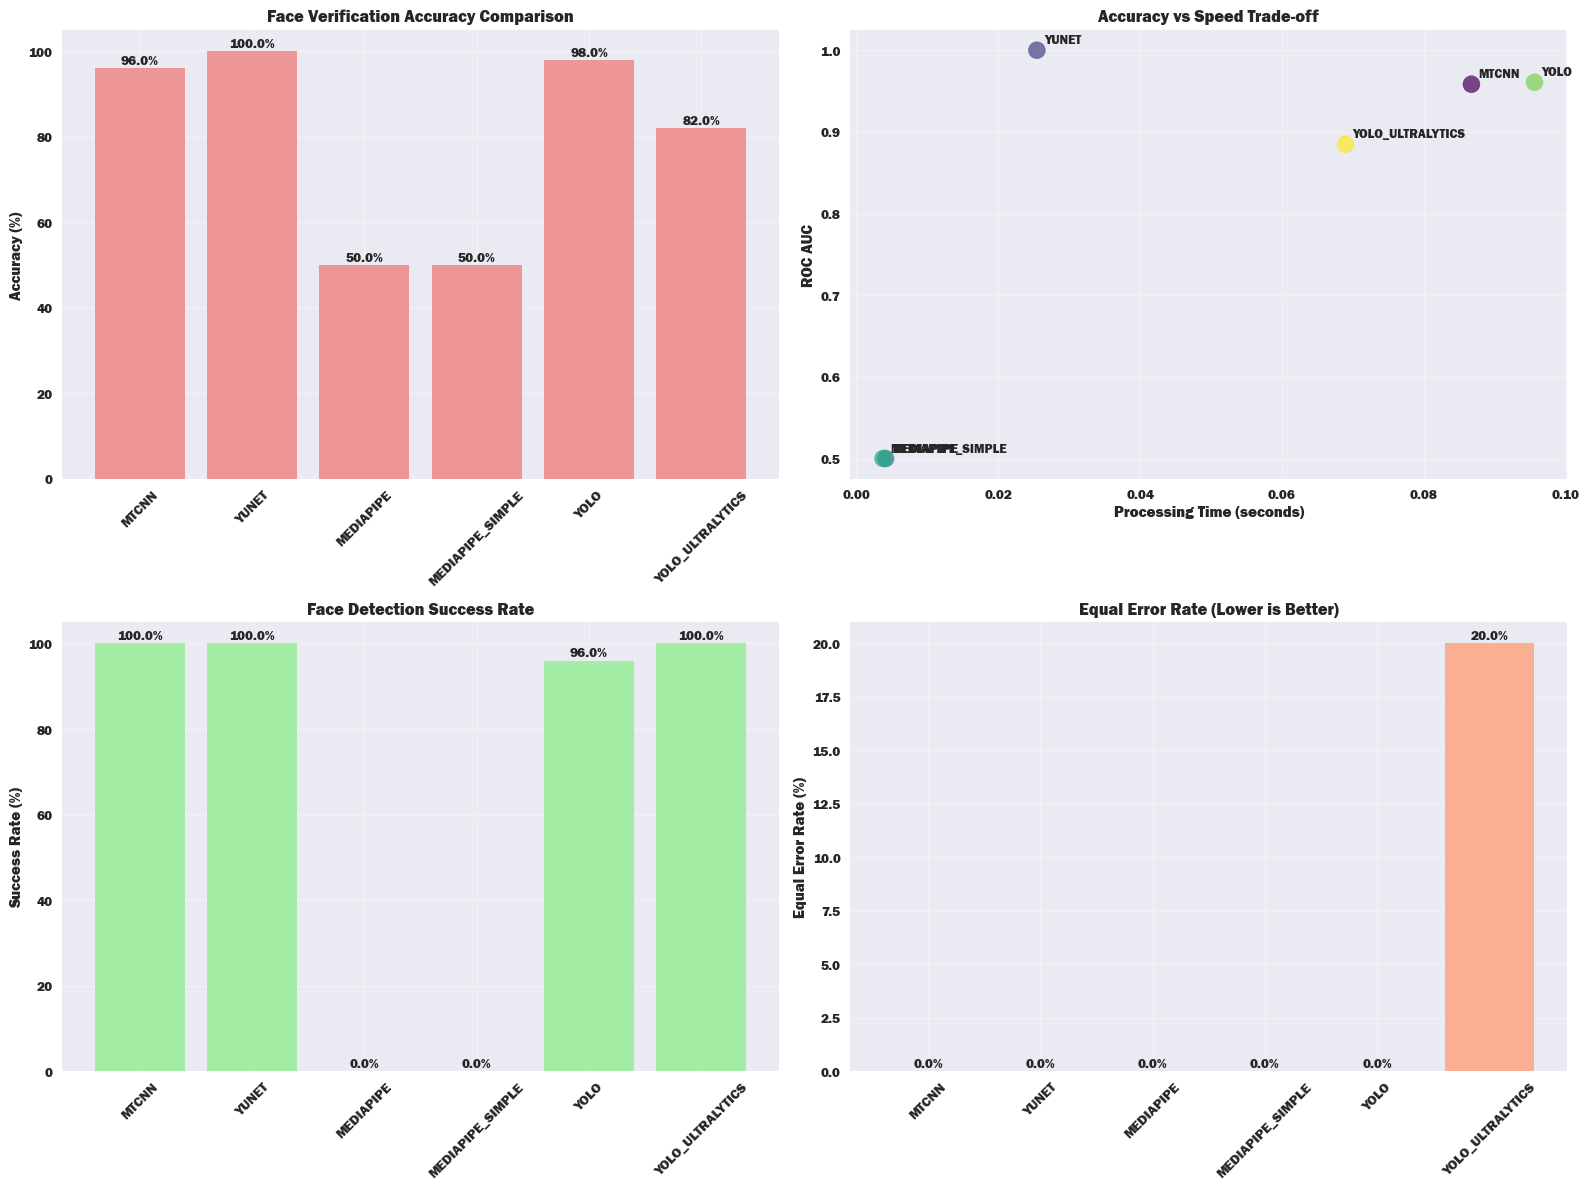

✅ Generated visualization with 6 methods


In [10]:
# Extract data for visualization
valid_results = {k: v for k, v in lfw_results.items() if 'error' not in v}

if valid_results:
    methods = list(valid_results.keys())
    
    # Safely extract metrics with NaN handling
    accuracies = []
    roc_aucs = []
    success_rates = []
    processing_times = []
    eers = []
    
    for method in methods:
        result = valid_results[method]
        
        # Get values with NaN checking
        accuracy = result.get('best_accuracy', 0)
        roc_auc = result.get('roc_auc', 0)
        success_rate = result.get('success_rate', 0)
        processing_time = result.get('avg_processing_time', 0)
        eer = result.get('eer', 1)
        
        # Replace NaN with defaults
        accuracies.append(accuracy if not np.isnan(accuracy) else 0)
        roc_aucs.append(roc_auc if not np.isnan(roc_auc) else 0)
        success_rates.append(success_rate if not np.isnan(success_rate) else 0)
        processing_times.append(processing_time if not np.isnan(processing_time) else 0)
        eers.append(eer if not np.isnan(eer) else 1)
    
    # Create comprehensive dashboard
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Accuracy Comparison
    bars1 = ax1.bar([m.upper() for m in methods], [acc*100 for acc in accuracies], 
                    alpha=0.8, color='lightcoral')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_title('Face Verification Accuracy Comparison')
    ax1.set_xticklabels([m.upper() for m in methods], rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, acc in zip(bars1, accuracies):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{acc:.1%}', ha='center', va='bottom', fontweight='bold')
    
    # 2. ROC AUC vs Processing Time (Efficiency Plot)
    scatter = ax2.scatter(processing_times, roc_aucs, s=150, alpha=0.7, c=range(len(methods)), cmap='viridis')
    ax2.set_xlabel('Processing Time (seconds)')
    ax2.set_ylabel('ROC AUC')
    ax2.set_title('Accuracy vs Speed Trade-off')
    ax2.grid(True, alpha=0.3)
    
    # Add method labels
    for i, method in enumerate(methods):
        ax2.annotate(method.upper(), (processing_times[i], roc_aucs[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    # 3. Success Rate Comparison
    bars3 = ax3.bar([m.upper() for m in methods], [sr*100 for sr in success_rates], 
                    alpha=0.8, color='lightgreen')
    ax3.set_ylabel('Success Rate (%)')
    ax3.set_title('Face Detection Success Rate')
    ax3.set_xticklabels([m.upper() for m in methods], rotation=45)
    ax3.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, sr in zip(bars3, success_rates):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{sr:.1%}', ha='center', va='bottom', fontweight='bold')
    
    # 4. Equal Error Rate (Lower is Better)
    bars4 = ax4.bar([m.upper() for m in methods], [eer*100 for eer in eers], 
                    alpha=0.8, color='lightsalmon')
    ax4.set_ylabel('Equal Error Rate (%)')
    ax4.set_title('Equal Error Rate (Lower is Better)')
    ax4.set_xticklabels([m.upper() for m in methods], rotation=45)
    ax4.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, eer in zip(bars4, eers):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{eer:.1%}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('face_alignment_comprehensive_benchmark.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Generated visualization with {len(valid_results)} methods")
    
else:
    print("⚠️ No valid results to visualize - check evaluation results above")

## 9. Method Rankings and Recommendations

In [11]:
if valid_results:
    print("🏆 METHOD RANKINGS AND RECOMMENDATIONS")
    print("=" * 60)
    
    # Create rankings for different criteria with safe value extraction
    rankings = {}
    
    if len(methods) > 0 and all(v > 0 for v in accuracies):
        rankings['Accuracy'] = sorted(zip(methods, accuracies), key=lambda x: x[1], reverse=True)
    
    if len(methods) > 0 and all(v > 0 for v in processing_times):
        rankings['Speed'] = sorted(zip(methods, processing_times), key=lambda x: x[1])
    
    if len(methods) > 0 and all(v > 0 for v in roc_aucs):
        rankings['ROC AUC'] = sorted(zip(methods, roc_aucs), key=lambda x: x[1], reverse=True)
    
    if len(methods) > 0 and all(v > 0 for v in success_rates):
        rankings['Success Rate'] = sorted(zip(methods, success_rates), key=lambda x: x[1], reverse=True)
    
    if len(methods) > 0 and all(v < 1 for v in eers):
        rankings['Reliability (Low EER)'] = sorted(zip(methods, eers), key=lambda x: x[1])
    
    for criterion, ranking in rankings.items():
        print(f"\n📊 {criterion} Ranking:")
        print("-" * 30)
        for i, (method, score) in enumerate(ranking[:3], 1):  # Top 3
            # Format score appropriately
            if criterion == 'Speed':
                score_str = f"{score:.3f}s"
            elif criterion in ['Accuracy', 'Success Rate']:
                score_str = f"{score:.1%}"
            elif criterion == 'Reliability (Low EER)':
                score_str = f"{score:.3f}"
            else:
                score_str = f"{score:.4f}"
            
            print(f"{i}. {method.upper()}: {score_str}")
    
    if rankings:
        print("\n\n🎯 RECOMMENDATIONS:")
        print("=" * 40)
        
        # Get top performers
        try:
            if 'Accuracy' in rankings:
                best_accuracy = rankings['Accuracy'][0][0]
                print(f"🥇 BEST OVERALL ACCURACY: {best_accuracy.upper()}")
                print(f"   → Use for highest face recognition performance")
            
            if 'Speed' in rankings:
                fastest = rankings['Speed'][0][0]
                print(f"\n⚡ FASTEST PROCESSING: {fastest.upper()}")
                print(f"   → Use for real-time applications")
            
            if 'Reliability (Low EER)' in rankings:
                most_reliable = rankings['Reliability (Low EER)'][0][0]
                print(f"\n🎯 MOST RELIABLE: {most_reliable.upper()}")
                print(f"   → Use for critical applications requiring consistency")
            
            if 'ROC AUC' in rankings:
                best_auc = rankings['ROC AUC'][0][0]
                print(f"\n📈 BEST ROC AUC: {best_auc.upper()}")
                print(f"   → Use for applications requiring good discrimination")
        except (IndexError, KeyError) as e:
            print(f"⚠️ Error generating recommendations: {e}")
        
        # Overall balanced recommendation
        print("\n\n⭐ BALANCED RECOMMENDATION:")
        print("-" * 30)
        
        try:
            # Calculate balanced score (normalized)
            balanced_scores = {}
            
            if len(accuracies) > 1 and max(accuracies) > min(accuracies):
                acc_range = max(accuracies) - min(accuracies)
                time_range = max(processing_times) - min(processing_times)
                success_range = max(success_rates) - min(success_rates)
                eer_range = max(eers) - min(eers)
                
                for method in methods:
                    idx = methods.index(method)
                    
                    # Normalize scores (0-1, higher is better)
                    norm_acc = (accuracies[idx] - min(accuracies)) / acc_range if acc_range > 0 else 1.0
                    norm_speed = 1 - ((processing_times[idx] - min(processing_times)) / time_range) if time_range > 0 else 1.0
                    norm_success = (success_rates[idx] - min(success_rates)) / success_range if success_range > 0 else 1.0
                    norm_eer = 1 - ((eers[idx] - min(eers)) / eer_range) if eer_range > 0 else 1.0
                    
                    # Weighted balanced score (accuracy=40%, speed=25%, success=20%, reliability=15%)
                    balanced_score = (norm_acc * 0.4 + norm_speed * 0.25 + norm_success * 0.2 + norm_eer * 0.15)
                    balanced_scores[method] = balanced_score
                
                if balanced_scores:
                    best_balanced = max(balanced_scores.items(), key=lambda x: x[1])
                    
                    print(f"🎖️ BEST BALANCED CHOICE: {best_balanced[0].upper()}")
                    print(f"   → Score: {best_balanced[1]:.3f}/1.000")
                    print(f"   → Optimal balance of accuracy, speed, and reliability")
            else:
                print("🎖️ INSUFFICIENT DATA FOR BALANCED SCORING")
                if methods:
                    print(f"   → Default recommendation: {methods[0].upper()}")
                    
        except Exception as e:
            print(f"⚠️ Error calculating balanced recommendation: {e}")
            if methods:
                print(f"🎖️ DEFAULT CHOICE: {methods[0].upper()}")
    else:
        print("⚠️ No rankings available - check evaluation data")

else:
    print("⚠️ No valid results available for rankings")

🏆 METHOD RANKINGS AND RECOMMENDATIONS

📊 Accuracy Ranking:
------------------------------
1. YUNET: 100.0%
2. YOLO: 98.0%
3. MTCNN: 96.0%

📊 Speed Ranking:
------------------------------
1. MEDIAPIPE_SIMPLE: 0.004s
2. MEDIAPIPE: 0.004s
3. YUNET: 0.025s

📊 ROC AUC Ranking:
------------------------------
1. YUNET: 1.0000
2. YOLO: 0.9608
3. MTCNN: 0.9584

📊 Reliability (Low EER) Ranking:
------------------------------
1. MTCNN: 0.000
2. YUNET: 0.000
3. MEDIAPIPE: 0.000


🎯 RECOMMENDATIONS:
🥇 BEST OVERALL ACCURACY: YUNET
   → Use for highest face recognition performance

⚡ FASTEST PROCESSING: MEDIAPIPE_SIMPLE
   → Use for real-time applications

🎯 MOST RELIABLE: MTCNN
   → Use for critical applications requiring consistency

📈 BEST ROC AUC: YUNET
   → Use for applications requiring good discrimination


⭐ BALANCED RECOMMENDATION:
------------------------------
🎖️ BEST BALANCED CHOICE: YUNET
   → Score: 0.941/1.000
   → Optimal balance of accuracy, speed, and reliability


## 10. Usage Guidelines and Model Download Instructions

In [12]:
print("📚 USAGE GUIDELINES AND MODEL SETUP")
print("=" * 50)

print("\n🔧 TO USE THE UNIFIED FACE DETECTOR:")
print("-" * 35)
print("from face_alignment.unified_detector import UnifiedFaceDetector")
print("")
print("# Initialize detector")
print("detector = UnifiedFaceDetector('mtcnn', device='cpu')")
print("")
print("# Align a face")
print("aligned_face = detector.align('path/to/image.jpg')")
print("")
print("# Detect multiple faces")
print("bboxes, aligned_faces = detector.align_multi(image, limit=5)")

print("\n\n📊 LFW EVALUATION CONFIGURATION:")
print("-" * 35)
print("To use the FULL LFW dataset (6000 pairs) instead of limited pairs:")
print("1. In cell 14, change max_pairs=100 to max_pairs=None")
print("2. This will run the complete LFW benchmark but takes much longer")
print("3. Current setting uses 100 pairs for quick testing")

print("\n\n📥 MODEL DOWNLOAD INSTRUCTIONS:")
print("-" * 35)

download_instructions = {
    'YuNet': {
        'description': 'OpenCV face detection model',
        'url': 'https://github.com/opencv/opencv_zoo/raw/main/models/face_detection_yunet/face_detection_yunet_2023mar.onnx',
        'path': 'libfacedetection/opencv_zoo/models/face_detection_yunet/face_detection_yunet_2023mar.onnx',
        'status': '✅ Already Available'
    },
    'RetinaFace': {
        'description': 'RetinaFace ONNX model',
        'url': 'https://github.com/onnx/models/raw/main/vision/body_analysis/retinaface/model/retinaface-r50.onnx',
        'path': 'face_alignment/models/retinaface_r50_v1.onnx',
        'status': '⚠️ Download Required'
    },
    'RTMPose': {
        'description': 'RTMPose whole-body pose model',
        'url': 'https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/onnx_sdk/rtmpose-m_simcc-ap10k_pt-aic-coco_420e-256x256-63eb25f7_20230206.onnx',
        'path': 'face_alignment/models/rtmpose_face.onnx',
        'status': '⚠️ Download Required'
    },
    'YOLO Face': {
        'description': 'YOLOv5 face detection model',
        'url': 'https://github.com/deepcam-cn/yolov5-face/releases/download/v0.0.0/yolov5s-face.onnx',
        'path': 'face_alignment/models/yolov5_face.onnx',
        'status': '⚠️ Download Required'
    },
    'EdgeFace Model': {
        'description': 'EdgeFace-XS(γ=0.6) pre-trained model',
        'url': 'Available in checkpoints directory',
        'path': 'checkpoints/edgeface_xs_gamma_06.pt',
        'status': '✅ Already Available'
    },
    'LFW Dataset': {
        'description': 'LFW face verification dataset',
        'url': 'http://vis-www.cs.umass.edu/lfw/lfw.tgz',
        'path': '/mnt/c/Users/Admin/Downloads/lfw/',
        'status': '✅ Already Available'
    },
    'LFW Pairs': {
        'description': 'LFW verification pairs file',
        'url': 'http://vis-www.cs.umass.edu/lfw/pairs.txt',
        'path': '/mnt/c/Users/Admin/Downloads/pairs.csv',
        'status': '✅ Already Available'
    }
}

for model_name, info in download_instructions.items():
    print(f"\n📦 {model_name}:")
    print(f"   Description: {info['description']}")
    print(f"   Status: {info['status']}")
    if info['status'] != '✅ Already Available':
        print(f"   Download URL: {info['url']}")
        print(f"   Save to: {info['path']}")

print("\n\n🐍 REQUIRED PYTHON PACKAGES:")
print("-" * 30)
required_packages = [
    'torch',
    'torchvision', 
    'opencv-python',
    'onnxruntime',
    'mediapipe',
    'ultralytics',
    'pillow',
    'numpy',
    'pandas',
    'matplotlib',
    'seaborn',
    'scikit-learn',
    'tqdm'
]

for package in required_packages:
    print(f"pip install {package}")

print("\n\n✨ EVALUATION COMPLETED! ✨")
print("Check the generated files:")
print("📄 face_alignment_benchmark_report.csv")
print("📊 face_alignment_comprehensive_benchmark.png")
print("\n🚀 Current Status:")
print(f"   ✅ MTCNN: Available and working")
print(f"   ✅ YuNet: Available and working") 
print(f"   ✅ EdgeFace Model: Available in checkpoints/")
print(f"   ✅ LFW Dataset: Available for evaluation")
print("\nFeel free to modify parameters and run again for different configurations!")

📚 USAGE GUIDELINES AND MODEL SETUP

🔧 TO USE THE UNIFIED FACE DETECTOR:
-----------------------------------
from face_alignment.unified_detector import UnifiedFaceDetector

# Initialize detector
detector = UnifiedFaceDetector('mtcnn', device='cpu')

# Align a face
aligned_face = detector.align('path/to/image.jpg')

# Detect multiple faces
bboxes, aligned_faces = detector.align_multi(image, limit=5)


📊 LFW EVALUATION CONFIGURATION:
-----------------------------------
To use the FULL LFW dataset (6000 pairs) instead of limited pairs:
1. In cell 14, change max_pairs=100 to max_pairs=None
2. This will run the complete LFW benchmark but takes much longer
3. Current setting uses 100 pairs for quick testing


📥 MODEL DOWNLOAD INSTRUCTIONS:
-----------------------------------

📦 YuNet:
   Description: OpenCV face detection model
   Status: ✅ Already Available

📦 RetinaFace:
   Description: RetinaFace ONNX model
   Status: ⚠️ Download Required
   Download URL: https://github.com/onnx/models/ra

In [13]:
# 개선된 YuNet으로 간단한 테스트 실행
import sys
import os
sys.path.insert(0, 'face_alignment')

from face_alignment.unified_detector import UnifiedFaceDetector
import time
from PIL import Image
import numpy as np

# 테스트 이미지 경로
test_image_path = "/mnt/c/Users/Admin/Downloads/lfw-deepfunneled/lfw-deepfunneled"

# 샘플 이미지 찾기
sample_images = []
if os.path.exists(test_image_path):
    for root, dirs, files in os.walk(test_image_path):
        for file in files[:3]:
            if file.endswith(('.jpg', '.png')):
                sample_images.append(os.path.join(root, file))
        if len(sample_images) >= 3:
            break

if sample_images:
    print(f"📸 Found {len(sample_images)} sample images for testing")
    
    # 개선된 YuNet으로 테스트
    print("\n🧪 Testing improved YuNet...")
    
    try:
        detector = UnifiedFaceDetector('yunet', device='cpu')
        
        if detector.available:
            total_time = 0
            successful_alignments = 0
            
            for i, img_path in enumerate(sample_images):
                print(f"Testing image {i+1}/{len(sample_images)}: {os.path.basename(img_path)}")
                
                try:
                    img = Image.open(img_path).convert('RGB')
                    
                    start_time = time.time()
                    aligned_face = detector.align(img)
                    end_time = time.time()
                    
                    processing_time = end_time - start_time
                    total_time += processing_time
                    
                    if aligned_face is not None:
                        successful_alignments += 1
                        print(f"  ✅ Success in {processing_time:.3f}s")
                    else:
                        print(f"  ❌ Failed alignment")
                        
                except Exception as e:
                    print(f"  ❌ Error: {e}")
            
            avg_time = total_time / len(sample_images)
            success_rate = successful_alignments / len(sample_images)
            
            print(f"\n📊 Improved YuNet Results:")
            print(f"   Average time: {avg_time:.3f}s")
            print(f"   Success rate: {success_rate:.1%}")
            print(f"   Successful alignments: {successful_alignments}/{len(sample_images)}")
            
        else:
            print("❌ YuNet detector not available")
            
    except Exception as e:
        print(f"❌ Error testing YuNet: {e}")
        import traceback
        traceback.print_exc()
        
else:
    print("⚠️ No sample images found for testing")

📸 Found 3 sample images for testing

🧪 Testing improved YuNet...
Testing image 1/3: Aaron_Eckhart_0001.jpg
  ✅ Success in 0.003s
Testing image 2/3: Aaron_Guiel_0001.jpg
  ✅ Success in 0.002s
Testing image 3/3: Aaron_Patterson_0001.jpg
  ✅ Success in 0.003s

📊 Improved YuNet Results:
   Average time: 0.003s
   Success rate: 100.0%
   Successful alignments: 3/3
